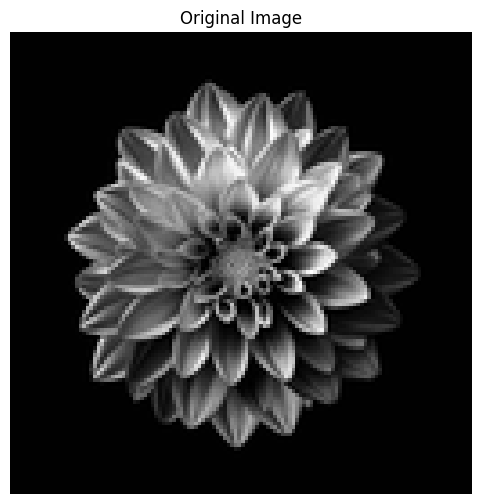

/home/justin/anaconda3/envs/aimldl/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


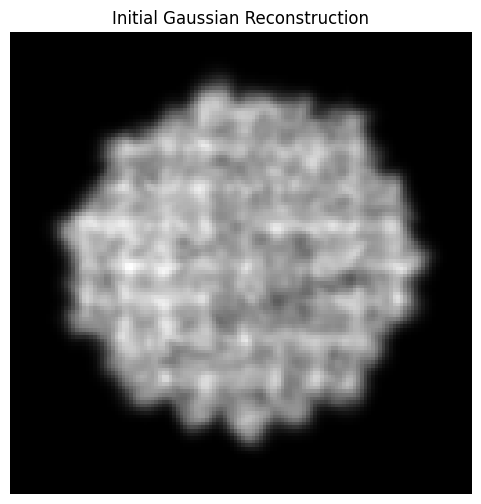

/tmp/ipykernel_28239/99730884.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_frames.append((torch.tensor(model).cpu().detach().numpy()))


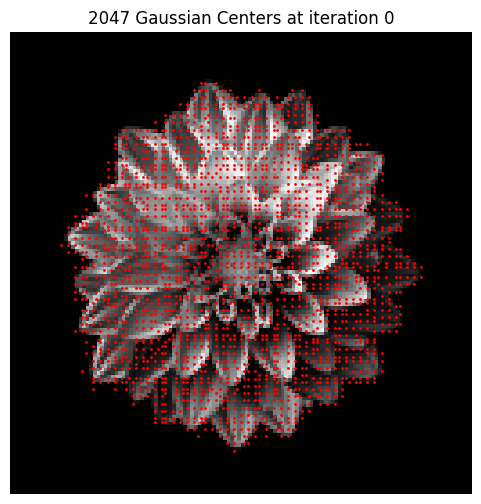

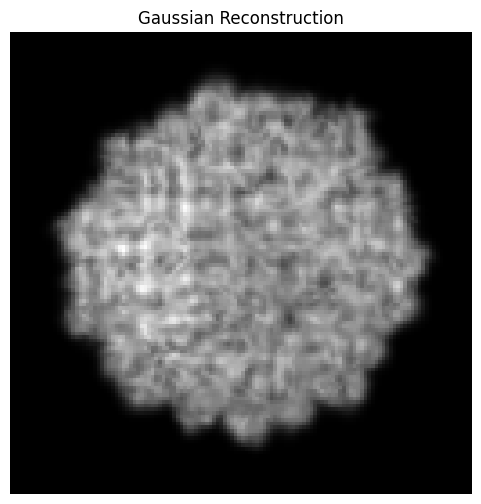

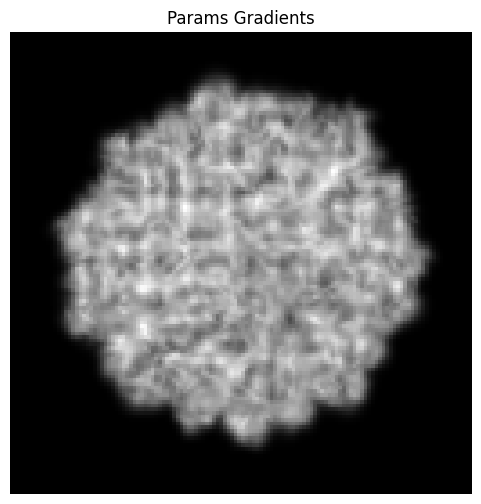

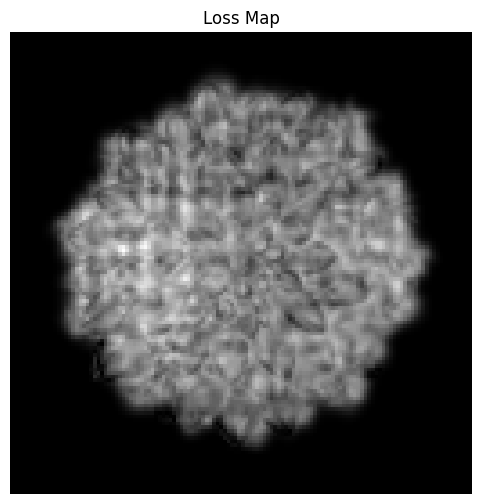

Iteration 0/300, Loss: 6.324910640716553, LR: 0.45
Iteration 10/300, Loss: 0.05452781170606613, LR: 0.45
Iteration 20/300, Loss: 0.03187864273786545, LR: 0.45
Iteration 30/300, Loss: 0.011953620240092278, LR: 0.45
Iteration 40/300, Loss: 0.006809758488088846, LR: 0.45


KeyboardInterrupt: 

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from IPython.display import Video, display
import time
# Load and normalize the image
image_path = 'data/flwr.jpg'
image = Image.open(image_path).convert('L')

desired_size = (128, 128)  # Desired resolution
image = image.resize(desired_size, Image.LANCZOS)

img_np = np.array(image) / 255.0
# img_np[img_np == 1] = 0
img_tensor = torch.tensor(img_np).float().cuda()
# img_tensor[img_tensor == 1] = 0
# print(img_tensor)
def plot_image(img_array, title, params=None, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.imshow(img_array, cmap=cmap)
    if params is not None:
        plt.scatter(params[::6], params[1::6], color='red', s=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the original image
plot_image(img_np, "Original Image")

# Define the 2D Gaussian function with a color intensity parameter and rotation angle
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle):
    # Calculate the centered coordinates
    x_centered = x - mu_x
    y_centered = y - mu_y
    
    # Rotate the coordinates
    x_rot = x_centered * torch.cos(rotation_angle) - y_centered * torch.sin(rotation_angle)
    y_rot = x_centered * torch.sin(rotation_angle) + y_centered * torch.cos(rotation_angle)
    
    exponent = -((x_rot**2) / (2*sigma_x**2) + (y_rot**2) / (2*sigma_y**2))
    # print(color_intensity)
    return (torch.exp(exponent)) * torch.sigmoid(color_intensity)

# Model the image using a set of rotated Gaussians
def model_image(params, shape):
    x = torch.linspace(0, shape[1] - 1, shape[1]).cuda()
    y = torch.linspace(0, shape[0] - 1, shape[0]).cuda()
    x, y = torch.meshgrid(x, y)
    model = torch.zeros_like(x)
    for i in range(0, len(params), 6): 
        mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle = params[i:i+6]
        model += gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle)
    
    return model

# Mean squared error loss function
def mse_loss(params):
    model = model_image(params, img_tensor.shape)
    # model -= model.min(1, keepdim=True)[0]
    # model /= model.max(1, keepdim=True)[0]
    loss = torch.mean((model - img_tensor)**2).requires_grad_()
    return loss
# Parameters for splitting and cloning
tau_prune = 1e-2  # Pruning threshold for amplitude
epsilon_split = 1e-3  # Perturbation for split Gaussians

tau_p = 5e-8  # Gradient magnitude threshold for densification
tau_S = 5.0  # Size threshold for over-reconstruction

def adaptive(params, gradients):
    updated_params = params.clone()
    
    to_remove = []  # Indices of Gaussians to be removed
    to_split = []  # Indices of Gaussians to be split (over-reconstruction)
    to_clone = []  # Indices of Gaussians to be cloned (under-reconstruction)

    for i in range(0, len(params), 6):
        _, _, sigma_x, sigma_y, color_intensity, _, = params[i:i+6]

        # Pruning: Zero out Gaussians with low amplitudes
        # print(torch.sigmoid(color_intensity))
        if torch.sigmoid(color_intensity) < tau_prune:
            to_remove.append(i)

    # Zero out the values for removal
    for i in to_remove:
        updated_params[i:i+6] = torch.tensor(0).cuda()
        print("pruning")

    # Handle splitting and cloning
    available_slots = iter(to_remove)
    # Densification based on gradient of loss
    for i in range(0, len(params), 6):
        if torch.norm(gradients[i:i+6]).float() > tau_p and params[i+4] !=0:
            if sigma_x.item() > tau_S or sigma_y.item() > tau_S:
                # Splitting for Over-reconstruction
                to_split.append(i)
            else:
                # Cloning for Under-reconstruction
                to_clone.append(i)
    for i in to_split:
        try:
            slot = next(available_slots)
            new_gaussian1, new_gaussian2 = split_gaussian(params, i)
            updated_params[slot:slot+6] = new_gaussian1
            slot = next(available_slots)
            updated_params[slot:slot+6] = new_gaussian2
        except StopIteration:
            break

    for i in to_clone:
        try:
            slot = next(available_slots)
            cloned_gaussian = clone_gaussian(params, i)
            updated_params[slot:slot+6] = cloned_gaussian
        except StopIteration:
            break

    params.data = updated_params.data
    params.requires_grad_()

    return params

def split_gaussian(params, index):
    new_gaussian1 = params[index:index+6].clone()
    new_gaussian2 = params[index:index+6].clone()

    # Perturb attributes to create two new Gaussians
    new_gaussian1[0:4] += torch.randn(4).cuda() * epsilon_split
    new_gaussian2[0:4] -= torch.randn(4).cuda() * epsilon_split
    print("splitting")
    return new_gaussian1, new_gaussian2

def clone_gaussian(params, index):
    cloned_gaussian = params[index:index+6].clone()
    cloned_gaussian[0:4] += torch.randn(4).cuda() * epsilon_split
    print("cloning")
    return cloned_gaussian

# Initialization using grid approach and sampling the image
num_gaussians = 5000
grid_size = int(np.sqrt(num_gaussians))
params = []
image_height, image_width = img_tensor.shape

for i in range(grid_size):
    for j in range(grid_size):
        # Calculate the coordinates within the image
        x_coord = (i * image_width) // grid_size
        y_coord = (j * image_height) // grid_size
        if img_tensor[y_coord, x_coord] < 1e-2:
            continue
        
        # Sample the color intensity from the image at the calculated coordinates
        color_intensity = torch.logit(img_tensor[y_coord, x_coord]).clamp(-3, 3).cuda()
        
        mu_x = torch.tensor(x_coord).float().cuda()
        mu_y = torch.tensor(y_coord).float().cuda()
        sigma_x = torch.randn(1).mul(0.5).add(2).clamp(1, 20).cuda()
        sigma_y = torch.randn(1).mul(0.5).add(2).clamp(1, 20).cuda()
        rotation_angle = torch.rand(1).mul(2 * np.pi).cuda()  # Random rotation angle
        
        params.extend([mu_x.item(), mu_y.item(), sigma_x.item(), sigma_y.item(), color_intensity.item(), rotation_angle.item()])

def visualize_grad(params, shape, model_img, img_tensor):
    x = torch.linspace(0, shape[1] - 1, shape[1]).cuda()
    y = torch.linspace(0, shape[0] - 1, shape[0]).cuda()
    x, y = torch.meshgrid(x, y)
    gmlist = []
    model_grad = torch.zeros_like(x)
    for i in range(0, len(params), 6): 
        mu_x, mu_y, sigma_x, sigma_y, _, rot = params[i:i+6]
        grad_mag = torch.norm(params.grad[i:i+6])
        gmlist.append(grad_mag.item())
        model_grad += gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, grad_mag, rot)

    plot_image(model_grad.cpu().detach().numpy(), "Params Gradients")   
    plot_image(np.abs(model_img - img_tensor), "Loss Map")


params = torch.tensor(params, device='cuda').requires_grad_()
optimizer = optim.Adam([params], lr=0.45) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# Display the initial Gaussian-based reconstruction
initial_model = model_image(params, img_tensor.shape).cpu().detach().numpy()
plot_image(initial_model, "Initial Gaussian Reconstruction")

# Optimize with scheduler step
iterations = 300
display_interval = 50  # Display the Gaussian centers every 100 iterations
all_frames = []
for iteration in range(iterations):
    optimizer.zero_grad()
    loss = mse_loss(params)
    loss.backward()
    optimizer.step()
    scheduler.step()
    model = model_image(params, img_tensor.shape)
    # model -= model.min(1, keepdim=True)[0]
    # model /= model.max(1, keepdim=True)[0]
    all_frames.append((torch.tensor(model).cpu().detach().numpy()))
    if iteration % display_interval == 0:
        if iteration !=0:
            adaptive(params, params.grad)
        #get count of params with low amplitude/color intensity
        active_gaussians = torch.sum(params[4::6] != 0)
        plot_image(img_np, f"{active_gaussians} Gaussian Centers at iteration {iteration}", params=params.cpu().detach().numpy())
        model = model_image(params, img_tensor.shape)
        plot_image(model.cpu().detach().numpy(), "Gaussian Reconstruction")
        visualize_grad(params, img_tensor.shape, model.cpu().detach().numpy(), img_tensor.cpu().detach().numpy())
    if iteration % 10 == 0:
        print(f"Iteration {iteration}/{iterations}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

# Display result
timestr = time.strftime("%Y%m%d-%H%M%S")
result = model_image(params, img_tensor.shape).cpu().detach().numpy()
all_frames = np.array(all_frames)
all_frames = all_frames.astype(np.float32)
min_val = all_frames[-1].min()
max_val = all_frames[-1].max()
all_frames = (all_frames - min_val) / (max_val - min_val)
all_frames = np.clip((all_frames * 255), 0, 255).astype(np.uint8) 
plot_image(img_np, "Original Image")
plot_image(result, "Final Gaussian Reconstruction")
video_path = './data/gaussian_reconstruction'+timestr+'.mp4'
imageio.mimwrite(video_path, all_frames, fps=12)
display(Video(video_path, width=512, height=512))